## CloudDBH

In [1]:
import numpy as np
import pandas as pd
import glob
import sys
import os
import gc
import open3d as o3d

from shapely.ops import cascaded_union, polygonize
from shapely.geometry import Polygon, LineString
import shapely.geometry as geometry

from scipy import optimize
from scipy.spatial import ConvexHull, convex_hull_plot_2d, Delaunay
import scipy.io as sio

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import math
from math import pi

from sklearn.neighbors import NearestNeighbors
from descartes import PolygonPatch

from sklearn.cluster import KMeans


# Functions

### From Calders et al. 2015

In [2]:
# Functions from Calders et al
# nearest neighbour needed for outlier removal
def nn(x,rad):
    """
    Function from TLS_Inventory.
    
    x: a numpy array, rad: radius to search for neighbors within
    
    My understanding - can either specify number of neighbors to return (in sklearn NearestNeighbors),
    or return all the neighbors and then filter to return only those within a specified distance radius
    """
    nbrs = NearestNeighbors(algorithm='auto', metric='euclidean').fit(x) 
    distances, indices = nbrs.radius_neighbors(radius=rad) #find all neighbours within this search radius
    
    #output explained: https://stackoverflow.com/questions/53886289/confused-with-the-output-of-sklearn-neighbors-nearestneighbors 
    return distances, indices


def load_pts(cloud,downsample=False,outliers=False): 
    """
    Function from TLS_Inventory that reads the point cloud data for single tree at a time and
    returns pandas dataframe with the points split into x, y, z coordinates. 
    
    cloud: point cloud from a single tree - note, point cloud data should be pre-processed and 
           split into individual trees prior to using this function.
    downsample (Optional): Default is False, meaning all the points are retained. If 
                           True, the point clouds are sampled to keep only fraction of points.
    outliers (Optional): Default is False, meaning outliers are retained. If True, 
    """
    # read the point cloud data for single tree and save as pandas df with columns for x, y, z coords
    dftemp=o3d.io.read_point_cloud(cloud)
    df=pd.DataFrame(data=np.asarray(dftemp.points),columns=['x', 'y', 'z']) #access the points
    
    # Optional downsampling
    if downsample:
        df=df.sample(frac=0.1) # keep 10pct of points
    
    # Optional outlier removal 
    if outliers: #remove outliers
        xy=df.iloc[:,0:2].values # takes ALL rows, first and second column - x and y - and .values converts to numpy array
        dist, indi = nn(xy,0.5) # get nearest neighbors within search radius of 0.5
        cnt=[len(i) for i in indi] # count the kNN within the search radius
        cnt = pd.DataFrame({'count':cnt})
        
        # set threshold for the number of neighbors we want to keep 
        threshold=df.shape[0]*0.0001 #1 neighbor for every 10 000 pts
        
        removed=sum(np.array(cnt)<threshold)
        df=df[np.array(cnt)>=threshold]
        print("Removed %i outliers using kNN threshold %.2f" % (removed[0], threshold-1))
    
    return df #return pandas dataframe 

### Helper Functions

In [3]:
def formatplots(trees, ncols=4, shape='square'):
    """
    Returns matplotlib fig and axs objects with desired shape and number of subplots.
    
    Args:
    trees - the list of trees (or other objects) that need to be plotted.
            the length of this list will be the number of subplots returned.
    ncols - the desired number of columns in the subplot grid 
    shape - optional argument describing the shape of the subplots. 
            Options are "square", "horiz", or "vert"
    
    Returns: 
    fig, axs - matplotlib objects corresponding to the grid of subplots
    """
    # determine number of subplots
    nplots = len(trees)
    
    # determine number of rows 
    if(nplots % ncols) != 0:
        nrows = int(nplots / ncols + 1)
    else:
        nrows = int(nplots / ncols)

    if shape == 'horiz':
        # initiate figure with nrows and ncols
        fig, axs = plt.subplots(nrows, ncols, figsize=(20,nrows*4))
        fig.tight_layout()
    if shape == 'vert':
        # initiate figure with nrows and ncols
        fig, axs = plt.subplots(nrows, ncols, figsize=(20,nrows*10))
        fig.tight_layout()
    if shape == 'square':
        # initiate figure with nrows and ncols
        fig, axs = plt.subplots(nrows, ncols, figsize=(20,nrows*5))
        fig.tight_layout()
    
    return fig, axs

In [4]:
def update_inds(treeind, rowind, colind, ncols):
    """
    Function to be used in combination with the formatplots function. This function 
    updates indices as necessary to loop through the subplots and plot data in each. 
    """
    # increase tree index to get to next tree
    treeind += 1

    if (treeind % ncols) != 0:
        colind += 1
    else:
        rowind +=1 
        colind = 0
    
    return treeind, colind, rowind

In [5]:
def construct_treeid(tree, ptspath):
    """
    
    """
    # For wytham woods tree dataset
    if str(ptspath).__contains__('DATA_clouds_ply'):
        if tree[-4:] != '.ply':
            tree = str(ptspath) + '/wytham_winter_' + str(tree) + '.ply' # TODO: don't hard code this
        else:
            tree = tree # TODO: make this more robust

        tree_num = tree.split("_")[-1].split(".")[0]
    
    # For tropical tree dataset - must have the leaf files already removed
    if str(ptspath).__contains__('Tropical_manual_ply'):
        if tree[-4:] != '.ply':
            tree = str(ptspath) + '/MLA01_2018_' + str(tree) + '.wood.ply' # TODO: don't hard code this
        else:
            tree = str(tree) # TODO: make this more robust

        tree_num = tree.split("_")[-1].split(".")[0]
    return tree, tree_num

In [6]:
def wytham_singlemulti(ptspath):
    """
    Function that splits the wytham woods dataset into single vs multistemmed trees 
    with string operations based on how the wytham dataset is named.
    """

    singlestemmed = []
    multistemmed = []
    
    # get list of trees from pts path
    trees = glob.glob("%s/*ply" % ptspath)
    
    for tree in trees:
        tree_num = tree.split("_")[-1].split(".")[0]
        
        # if the treeID ends in a letter, it is not single stem
        if tree_num[-1].isalpha():
            multistemmed.append(tree)
        else:
            singlestemmed.append(tree)

    return singlestemmed, multistemmed

### Tree Functions

In [7]:
def calc_convexhull(tree, ptspath, hgt=1.3, cluster_pts=None):
    """
    Function to calculate and plot convex hulls for each tree in a list of trees.
    
    Returns: 
        dbh - value for diameter at the specified height 
        verts - number of vertices used in calculating convex hull 
        pts_dbh - the 3D point dataset for the given slice (for plotting)
    """

    # Get treeID and ensure inputted format is correct
    tree, tree_num = construct_treeid(tree, ptspath)

    # get DBH from full cloud to preserve max number of hits on stem slice
    pts = load_pts(tree,False,False)
    
    # extract part of df with z values between 1.27 and 1.33 m by default - Tansey et al. 2009, Calders et al. 2015
    pts_dbh = pts[(pts['z'] > pts['z'].min() + hgt - 0.03) & (pts['z'] < pts['z'].min() + hgt + 0.03)]
    
    if cluster_pts is not None:
        pts_dbh = cluster_pts
    
    xy_dbh_arr = np.asarray(pts_dbh[['x', 'y']])

    # Calculate DBH (convex hull) using scipy ConvexHull
    hull = ConvexHull(xy_dbh_arr)
    
    # calculate return values
    dbh = hull.area / np.pi
    verts = len(hull.vertices)
    
    
                      
    return dbh, verts, pts_dbh, hull
    

In [8]:
# TODO: redo this function so it takes in better args
def plot_convexhull(treelist, ptspath, ncols=4, fixedheight = True, hgt=1.3, hgtlist = None):
    fig, axs = formatplots(treelist, ncols)
    rowind = colind = treeind = 0
    
    for tree in treelist:
        tree, tree_num = construct_treeid(tree, ptspath)
        
        if fixedheight:
            hgt = hgt
        else:
            hgt = hgtlist[tree_num]
        
        dbh_cv, verts, pts_dbh, hull = calc_convexhull(tree, pts_path, hgt=hgt)
        xy_dbh_arr = np.asarray(pts_dbh[['x', 'y']])
        
        
        axs[rowind, colind].scatter(pts_dbh['x'], pts_dbh['y']) 
        
        # plot line connecting all the dbh vertices
        for simplex in hull.simplices:
            axs[rowind, colind].plot(xy_dbh_arr[simplex, 0], xy_dbh_arr[simplex, 1], 'r--')
        
        axs[rowind, colind].plot(xy_dbh_arr[hull.vertices,0], xy_dbh_arr[hull.vertices,1], 'r--', label=f"DBH: {dbh_cv:.3f}") # DBH (convex hull)
        axs[rowind, colind].plot(xy_dbh_arr[hull.vertices,0], xy_dbh_arr[hull.vertices,1], 'ro', label=f"Vertices: {len(hull.vertices)}") # vertices

        axs[rowind, colind].set_title(f'DBH (Convex Hull) for {tree_num}')
        axs[rowind, colind].legend(fontsize='xx-large', loc='upper left')
        axs[rowind, colind].axis('equal')

        treeind, colind, rowind = update_inds(treeind, rowind, colind, ncols)
    return

In [9]:
def iter_dbh(tree, ptspath, step=0.1, lim=10, verbose=False):
    """
    Start from bottom of tree and calculate convex hull in 0.06m slices separated
    by defined step size until limit. 
    """

    # Get treeID
    tree, tree_num = construct_treeid(tree, ptspath)

    #get DBH from full cloud to preserve max number of hits on stem slice
    pts = load_pts(tree,False,False)

    # calculate dbh for slices up to smaller of lim or tree height
    disc = 0.1
    hgt = pts['z'].max() - pts['z'].min()
    
    # set the limit equal to the smaller of tree height and defined limit
    lim = min(hgt, lim)
    
    # empty lists to hold values for each tree
    dbh_list = []
    vert_list = []
    disc_list = []

    # loop upward through height of tree (up to lim)
    while disc < lim:
        # Calculate DBH (convex hull) for current slice using scipy ConvexHull
        pts_slice = pts[(pts['z'] > pts['z'].min() + disc - 0.03) & (pts['z'] < pts['z'].min() + disc + 0.03)]
        xy_dbh = np.asarray(pts_slice[['x', 'y']])

        if len(xy_dbh) < 3:
            if verbose: print(f'tree {tree_num} had not enough points at disc {disc}')
            dbh_list.append(np.nan)
            vert_list.append(np.nan)
            disc_list.append(round(disc, 1))
            disc += step
            continue

        circum = ConvexHull(xy_dbh) 
        
        dbh = circum.area / np.pi
        verts = len(circum.vertices)

        # append data to lists
        dbh_list.append(dbh)
        vert_list.append(verts)
        disc_list.append(round(disc, 1))

        # move up to next slice  
        disc += step
    
    df_out = pd.DataFrame(list(zip(dbh_list, vert_list, disc_list)), columns = ['DBH_CV', 'DBH_Verts', 'Slice_Hgt'])
    
    return df_out
            

In [10]:
def plot_iter_dbh(treelist, ptspath, ncols = 2, step=0.1, slope_thresh=0.1, dbh_thresh=2):
    """
    Takes the output of function iter_dbh and plots results in grid.
    """
    
    # format plotting grid
    fig, axs = formatplots(treelist, ncols, shape='horiz')
    rowind = colind = treeind = 0

    for tree in treelist:
        
        # Get treeID
        tree, tree_num = construct_treeid(tree, ptspath)
        
        # get dataframe of iterdbh function
        treedf = iter_dbh(tree, ptspath, step=step, lim=10)
        
        # get height for dbh for the tree 
        hgt = get_dbh_hgt(tree, ptspath, step=step, slope_thresh=slope_thresh, dbh_thresh=dbh_thresh)
        hgtplot = treedf['Slice_Hgt'] == hgt
        
        # get buttress height 
        buttress_hgt, treedf = get_buttress_hgt(tree, ptspath, step=step, lim=10, slope_thresh = slope_thresh)
        buttressplot = treedf['Slice_Hgt'] == buttress_hgt
        
        
        # plot data
        axs[rowind, colind].scatter(treedf['Slice_Hgt'], treedf['DBH_CV'])
        axs[rowind, colind].set_title(f'DBH w Height for {tree_num}, Slope Thresh: {slope_thresh}', fontsize=20)
        axs[rowind, colind].set_xlabel('Height of DBH Slice (m)', fontsize=20)
        axs[rowind, colind].set_ylabel('Value of DBH Slice (m)', fontsize=20)
        axs[rowind, colind].plot(treedf['Slice_Hgt'][hgtplot], treedf['DBH_CV'][hgtplot],'r+', markersize=30)
        axs[rowind, colind].plot(treedf['Slice_Hgt'][buttressplot], treedf['DBH_CV'][buttressplot],'b+', markersize=30)
        
        # plot all flagged points
        flagdf = flag_irregular(tree, ptspath, step=step, slope_thresh=slope_thresh, lim=10, dbh_thresh = dbh_thresh)
        flagged = flagdf[flagdf['Flagged'] == 1]
        axs[rowind, colind].plot(flagged['Slice_Hgt'], flagged['DBH_CV'],'r+', markersize=20)
        
        
        fig.tight_layout()

        
        treeind, colind, rowind = update_inds(treeind, rowind, colind, ncols)
    
    return

In [11]:
def get_buttress_hgt(tree, ptspath, step=0.1, lim=10, slope_thresh = 0.1, verbose=False):
    """
    Parameters:
    tree - 
    ptspath - 
    step - 
    lim - 
    slope_thresh - slope threshold above which points are flagged as part of a buttress
    """
    
    # Get treeID
    tree, tree_num = construct_treeid(tree, ptspath)
    
    # run iterative dbh for specified step size and lim to calc slopes
    treedf = iter_dbh(tree, ptspath, step=step, lim=lim)
    
    # calculate slope between pair of dbh measurements
    for disc in treedf['Slice_Hgt'].iloc[1:-1]:

        # round disc heights to one decimal place
        disc = round(disc, 1)
        prev_disc = round(disc - step, 1)

        # get dbh values at each disc height
        val1 = treedf[treedf['Slice_Hgt'] == disc]['DBH_CV'].iloc[0]
        val2 = treedf[treedf['Slice_Hgt'] == prev_disc]['DBH_CV'].iloc[0]

        # calculate slope between dbh measurements
        slope = (val1 - val2) / step

        # make new column in treedf for slope
        treedf.loc[treedf['Slice_Hgt'] == prev_disc, 'slope'] = slope

        # flag slope values greater than given threshold
        if abs(slope) > slope_thresh:
            if slope < 0: treedf.loc[treedf['Slice_Hgt'] == prev_disc, 'Buttress'] = -1
            if slope > 0: treedf.loc[treedf['Slice_Hgt'] == prev_disc, 'Buttress'] = 1

        else:
            treedf.loc[treedf['Slice_Hgt'] == prev_disc, 'Buttress'] = 0
        
    # if first three points are not flagged as buttress points:
    if all(np.array(treedf['Buttress'].iloc[0:3]) == np.array([0, 0, 0])):
        # set buttress height to 0.0 (i.e. bottom of tree stem)
        buttress_index = 0
        buttress_hgt = 0.0

    # otherwise, find height of top of buttress
    else:
        try:
            # find first sequence of three 0's (non-buttress points) that come after a negative slope 
            val_find = np.array([-1, 0, 0, 0])
            df_condition = treedf['Buttress'].rolling(4).apply(lambda g: all(g.astype(int) == val_find), raw=True)
            
            # get the index where three 0's first occurs and height of buttress
            buttress_index = np.where(df_condition == 1)[0][0]
            buttress_hgt = treedf['Slice_Hgt'].iloc[buttress_index]
        
        except:
            if verbose: print(f"tree {tree_num}: no suitable place to measure dbh from. Setting buttress height to 0.1m by default.")
            
            buttress_hgt = 0.1
               
    return buttress_hgt, treedf

In [12]:
def flag_irregular(tree, ptspath, step=0.1, slope_thresh=0.1, lim=10, dbh_thresh = 2):
    """
    Flag any irregular parts of the tree stem to avoid using them for dbh.
    
    Using a rolling mean to easily account for/ avoid the influence of extremely 
    small outliers that may be caused by data occlusion. 
    """
    # run iterative dbh for specified step size and lim to calc slopes
    treedf = iter_dbh(tree, ptspath, step=step, lim=lim)
    
    # get buttress height and subset dataframe to parts over the buttress
    buttress_hgt, treedf = get_buttress_hgt(tree, ptspath, step=step, lim=lim, slope_thresh=slope_thresh)
    over_buttress = treedf[treedf["Slice_Hgt"] > buttress_hgt]
    
    # calculate a max dbh threshold - no greater 2 * minimum rolling mean dbh
    dbh_thresh = np.nanmin(over_buttress['DBH_CV'].rolling(3).mean()) * dbh_thresh
    
    # create a filter using this threshold
    dbh_filt = treedf['DBH_CV'] > dbh_thresh
    
    # flag values greater than the threshold
    treedf.loc[dbh_filt, 'Flagged'] = 1
    treedf.loc[~dbh_filt, 'Flagged'] = 0

    return treedf

In [13]:
def get_dbh_hgt(tree, ptspath, step=0.1, slope_thresh=0.1, lim=10, dbh_thresh = 2):
    """
    Take output of iter_dbh function and determine ideal height from which to calculate dbh
    
    Note: the rolling search doesn't seem to work if there is no buttress so this is broken up into 
    if else - TODO: but could simplify if I figure out how to fix the else part of the code to work
    for non buttressed trees too 
    """
    # Get treeID
    tree, tree_num = construct_treeid(tree, ptspath)

    # get buttress height
    buttress_hgt, treedf = get_buttress_hgt(tree, ptspath, step=step, lim=lim, slope_thresh=slope_thresh)
    
    # flag irregular points to be excluded from dbh height consideration
    treedf = flag_irregular(tree, ptspath, step=step, slope_thresh=slope_thresh, lim=lim, dbh_thresh = dbh_thresh)

    # subset treedf to only above buttress height
    over_buttress = treedf[treedf["Slice_Hgt"] > buttress_hgt]
    
    # select only non-flagged data
    filt = over_buttress['Flagged'] == 1
    validdf = over_buttress[~filt]

    # get suitable value closest to 1.3m to use for dbh height
    disclist = list(validdf['Slice_Hgt'])
    dif = lambda disclist : abs(disclist - 1.3)
    hgt = min(disclist, key=dif)

    return hgt

In [14]:
def plot2D(trees, ptspath, ncols=4, dbh=True, iterdbh=False, hgtlist = None):
    """
    Function to plot tree point clouds in x/z or y/z direction
    
    TODO: make iter dbh function work on just one tree - then call iter_dbh from within this function
    """
    # determine number of rows to plot figures
    fig, axs = formatplots(trees, ncols)
    rowind = colind = treeind = 0

    # loop through trees
    for tree in trees:
        # Get treeID
        tree, tree_num = construct_treeid(tree, ptspath)

        #get DBH from full cloud to preserve max number of hits on stem slice
        pts = load_pts(tree,False,False)

        # calculate tree height
        tree_hgt = pts['z'].max() - pts['z'].min()
            
        max_pt = pts[pts['z'] == pts['z'].max()]

        # plot scatter plot of points in x and z 
        axs[rowind, colind].scatter(pts['x'], pts['z'], s=3) 
        if dbh: 
            pts_dbh = pts[(pts['z'] > pts['z'].min() + 1.27) & (pts['z'] < pts['z'].min() + 1.33)]
            axs[rowind, colind].plot(pts_dbh['x'], pts_dbh['z'], 'ro', markersize=3, label=f"DBH Slice")
        
        if iterdbh: 
            hgt = hgtlist[tree_num]
            pts_hgt = pts[(pts['z'] > pts['z'].min() + hgt - 0.03) & (pts['z'] < pts['z'].min() + hgt + 0.03)]
            axs[rowind, colind].plot(pts_hgt['x'], pts_hgt['z'], 'yo', markersize=3, label=f"HGT Slice")
            

        axs[rowind, colind].annotate(f'Height: {tree_hgt:.2f}', xy=(max_pt['x'].iloc[0], max_pt['z'].iloc[0]), va='top', ha='left', size=15)
        axs[rowind, colind].legend(fontsize='xx-large', loc='upper left')
        axs[rowind, colind].set_title(f'{tree_num} ({rowind}, {colind})')

        # increase tree index to get to next tree
        treeind, colind, rowind = update_inds(treeind, rowind, colind, ncols)
    return



## Multi-Stem Functions

In [15]:
def split_stems(tree, ptspath, nclusters, fixedheight = True, hgt=1.3, hgtlist = None):
    """
    Looks at the tree point cloud at the desired height (either 1.3m or the optimal dbh height)
    and splits the data into clusters representing tree stems.
    """
    
    tree, tree_num = construct_treeid(tree, trop_pts_path)

    if fixedheight:
        hgt = hgt
    else:
        hgt = hgtlist[tree_num]

    #get DBH from full cloud at desired height 
    pts = load_pts(tree,False,False)
    pts_dbh = pts[(pts['z'] > pts['z'].min() + hgt - 0.03) & (pts['z'] < pts['z'].min() + hgt + 0.03)]
    
    # create clustering object with desired number of clusters
    kmeans = KMeans(nclusters, n_init='auto')

    # Fit data to the defined number of clusters
    kmeans.fit(pts_dbh)

    # Get labels for each point 
    labels = kmeans.labels_
    
    return labels

In [16]:
def fit_circle(circle_pts):
    """ fit the circle to the point cloud and calculate dbh, residuals, etc."""
    # define subfunctions used to describe how well circle fits cross section 
    def calc_R(x,y, xc, yc):
        """ 
        calculate the distance of each 2D points from the center (xc, yc) 
        calc_R() from Calders et al. 2015 (https://doi.org/10.5281/zenodo.7307956)
        """
        return np.sqrt((x-xc)**2 + (y-yc)**2)

    def f(c, x, y):
        """ 
        calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc) 
        f() from Calders et al. 2015 (https://doi.org/10.5281/zenodo.7307956)
        """
        Ri = calc_R(x, y, *c)
        return Ri - Ri.mean()
    
    x = circle_pts['x']
    y = circle_pts['y']

    x_m = x.mean() # as first estimte of center
    y_m = y.mean()

    center_estimate = x_m, y_m

    # optimize for the distance between data points and circle centered at the center estimate
    center, ier = optimize.leastsq(f, center_estimate, args=(x,y)) 
    xc, yc = center
    Ri = calc_R(x, y, *center)
    R = Ri.mean()
    dbh_circ = R * 2.0
    residu = np.sum((Ri - R)**2)/len(Ri) # average residual between data points and circle fit

    return residu, dbh_circ, xc, yc, circle_pts

In [17]:
def check_overlap(circle_dict):
    """ checks how much overlap between circles and disregards if more than 10% overlap """
    
    labels = list(circle_dict.keys())
    
    i = 0
    j = 1
    
    # initialize overlap to False
    overlap = False 
    
    # loop through each pair of circles and check overlap
    while j < len(labels) and i < len(labels):

        # pull circle values out of the dictionary passed into function
        r1 = circle_dict[labels[i]]['r']
        r2 = circle_dict[labels[j]]['r']

        xc1 = circle_dict[labels[i]]['xc']
        yc1 = circle_dict[labels[i]]['yc']

        xc2 = circle_dict[labels[j]]['xc']
        yc2 = circle_dict[labels[j]]['yc']

        # calculate distance between centers of circles
        dist = math.sqrt((xc1 - xc2) * (xc1 - xc2) + (yc1 - yc2) * (yc1 - yc2))

        
        if dist <= (r1 - r2) or dist <= (r2 - r1):
            overlap = True
        
        # if circles overlap more than 10%, disregard 
        if dist < (r1 + r2) * 0.9:
            overlap = True

        # if j+1 is still less than the number of labels, increase j by 1
        if j + 1 < len(labels):
            j+=1

        elif j + 1 >= len(labels) and i + 1 <= len(labels):
            i+=1
            j = i+1

            
    return overlap

In [18]:
def get_n_stems(tree, ptspath, maxstems = 4, fixedheight = True, hgt=1.3, hgtlist = None):
    # start with one stem 
    tree, tree_num = construct_treeid(tree, trop_pts_path)
    
    if fixedheight:
        hgt = hgt
    else:
        hgt = hgtlist[tree_num]
    
    # get DBH from full cloud at desired height 
    pts = load_pts(tree,False,False)
    pts_dbh = pts[(pts['z'] > pts['z'].min() + hgt - 0.03) & (pts['z'] < pts['z'].min() + hgt + 0.03)]
    
    # initialize data dictionaries 
    residuals = {}
    circ_vals = {}

    # loop through checking residuals and overlap for number of possible stems up to the max 
    for stems in range(1, maxstems):
        
        # cluster the points into the specified number of stems 
        labels = split_stems(tree, ptspath, nclusters=stems, fixedheight = fixedheight, hgt=hgt, hgtlist = hgtlist)

        # empty the dictionaries to hold values for each set of stems
        inner_residuals = {}
        inner_circ_vals = {}

          
        enough_pts = True
        # fit a circle to each of the clusters
        for label in np.unique(labels):
            # get points for the stem of interest and fit a circle to the points
            circle_pts = pts_dbh[labels == label]
            
            # check how many points in this cluster
            if len(circle_pts) <= 3:
                enough_pts = False
                break
            
            
            residu, dbh_circ, xc, yc, circle_pts = fit_circle(circle_pts)

            # append the circle data to the dictionary
            inner_circ_vals[label] = {'r': dbh_circ/2.0, 'xc': xc, 'yc':yc}

            # add residual value to list 
            inner_residuals[label] = residu
            
            
            
            
        # check overlap between circles
        overlap = check_overlap(inner_circ_vals)

        # if the circles don't overlap:
        if overlap == False and enough_pts == True:
            # average the residuals for each tree stem and add to dict
            resid_list = []
            for stem, resid in inner_residuals.items():
                resid_list.append(resid)
            
            avg_resid = np.mean(resid_list)
            
            # add the data for each tree stem to the dict
            residuals[stems] = avg_resid
            circ_vals[stems] = inner_circ_vals
    
    nstems = min(residuals, key=residuals.get)
        
    return nstems
    

In [19]:
def how_circular(tree, ptspath, nstems = 1, fixedheight = True, hgt=1.3, hgtlist = None):
    """
    Returns metrics describing how well circle fits the cross section.
    https://scipy-cookbook.readthedocs.io/items/Least_Squares_Circle.html
    """
    
    tree, tree_num = construct_treeid(tree, trop_pts_path)
        
    if fixedheight:
        hgt = hgt
    else:
        hgt = hgtlist[tree_num]
    
    
    # get DBH from full cloud at desired height 
    pts = load_pts(tree,False,False)
    pts_dbh = pts[(pts['z'] > pts['z'].min() + hgt - 0.03) & (pts['z'] < pts['z'].min() + hgt + 0.03)]
    
    labels = split_stems(tree, trop_pts_path, nclusters = nstems, fixedheight = fixedheight, hgt=hgt, hgtlist = hgtlist)
    
    datadict = {}
    
    # cycle through labels (tree stems)
    for label in np.unique(labels):
        
        # empty the inner dict to hold data
        innerdict = {}

        # get points for the stem of interest and fit a circle to the points
        circle_pts = pts_dbh[labels == label]

        residu, dbh_circ, xc, yc, circle_pts = fit_circle(circle_pts)

        # construct data dictionaries
        innerdict = {'residual': residu, 'dbh_circ': dbh_circ, 'xc': xc, 'yc':yc, 'circle_pts':circle_pts, 'hgt': hgt}
        datadict[label] = innerdict

    
    return datadict


# Main Code

In [20]:
# Wytham Woods
wytham_pts_path = "/Users/snix/Documents/2021-2023/UCL/Dissertation/DATA_clouds_ply"
wytham_qsm_path = "/Users/snix/Documents/2021-2023/UCL/Dissertation/DATA_QSM_opt/"
tree_csv_path = "/Users/snix/Documents/2021-2023/UCL/Dissertation/Calders Et Al/analysis_and_figures/trees_summary.csv"

# Tropical Trees
trop_pts_path = '/Users/snix/Documents/2021-2023/UCL/Dissertation/Tropical_manual_ply'
trop_csv_path = '/Users/snix/Documents/2021-2023/UCL/Dissertation/MLA01_man.csv'

In [21]:
# Get lists of wytham and tropical trees
wytham_trees = glob.glob("%s/*ply" % wytham_pts_path)
trop_trees = glob.glob("%s/*wood.ply" % trop_pts_path)

# Split wytham trees into single/multi stemmed
singlestemmed, multistemmed = wytham_singlemulti(wytham_pts_path)

print(f'Singlestemmed: {len(singlestemmed)}')
print(f'Multistemmed: {len(multistemmed)}')

Singlestemmed: 585
Multistemmed: 291


## Get DBH Heights, Calculate Convex Hull

In [36]:
def get_tree_data(treelist, ptspath, slope_thresh = 0.1, dbh_thresh = 2, verbose=False):
    """
    Main function that runs other functions and fills dictionaries with data on the trees """
    
    ## create empty dictionaries to hold data
    hgt_dict = {}
    dbh_13_dict = {}
    dbh_adj_dict = {}
    stems_dict = {}
    
    # cycle through trees and fill dictionaries with optimal height and convex hull values
    for tree in treelist:
        tree, tree_num = construct_treeid(tree, ptspath)
        if verbose: print(f'running {tree_num}')

        # calculate convex hull at 1.3m
        dbh_13, verts_13, pts_dbh_13, hull_13 = calc_convexhull(tree, ptspath, hgt=1.3)
        dbh_13_dict[tree_num] = dbh_13

        # determine optimal height from which to calculate dbh
        hgt = get_dbh_hgt(tree, ptspath, step=0.1, slope_thresh=slope_thresh, lim=10, dbh_thresh=dbh_thresh)
        hgt_dict[tree_num] = hgt

        # get number of stems at the optimal height 
        if treelist == trop_trees:
            nstems = get_n_stems(tree, ptspath, fixedheight = False, hgt=1.3, hgtlist = hgt_dict)
        # the wytham dataset is already split into single and multi-stemmed trees
        else:
            nstems = 1
        
        # add the number of stems to the dictionary
        stems_dict[tree_num] = nstems

        # get height at which to calculate convex hull and the points at that height
        pts = load_pts(tree,False,False)
        pts_dbh = pts[(pts['z'] > pts['z'].min() + hgt - 0.03) & (pts['z'] < pts['z'].min() + hgt + 0.03)]

        # if the tree has multiple stems
        if nstems != 1:
            labels = split_stems(tree, ptspath, nclusters=nstems, fixedheight = False, hgtlist = hgt_dict)
            dbh_adj_list = []

            # calculate convex hull for each stem (each 'label') separately
            for label in np.unique(labels):
                circle_pts = pts_dbh[labels == label]
                dbh_adj, verts_adj, pts_dbh_adj, hull_adj = calc_convexhull(tree, ptspath, hgt=hgt, cluster_pts = circle_pts)
                dbh_adj_list.append(dbh_adj)
                #print(f'tree {tree_num}, label: {label}, dbh_adj: {dbh_adj:.2f}')

            # average the dbh values for each stem and add to dictionary
            dbh_adj = np.mean(dbh_adj_list)
            dbh_adj_dict[tree_num] = dbh_adj

        else:
            dbh_adj, verts_adj, pts_dbh_adj, hull_adj = calc_convexhull(tree, ptspath, hgt=hgt, cluster_pts = None)
            dbh_adj_dict[tree_num] = dbh_adj
    
    return hgt_dict, dbh_13_dict, dbh_adj_dict, stems_dict



In [147]:
def write_data_csv(treelist, dict_list, col_names, agg_multi = False, write_csv=False, o_path=None):
    """
    Takes the dictionaries resulting from get_tree_data, creates a combined dataframe and writes to csv
    """
    
    # turn output dictionaries into a combined dataframe
    dfs = []
    for data_dict, column_name in zip(dict_list, col_names):
        df = pd.DataFrame.from_dict(data_dict, orient='index').reset_index()
        df.columns = ['TLS_ID', column_name]
        dfs.append(df)

    # merge resulting dataframes into one large dataframe 
    merged_df = dfs[0].merge(dfs[1],on='TLS_ID').merge(dfs[2],on='TLS_ID').merge(dfs[3],on='TLS_ID')
    
    if agg_multi and treelist == multistemmed:
    # if running for multistemmed wytham trees, need to aggregate by row
        print('in multistemmed')
        merged_df['StemID'] = merged_df['TLS_ID'].str[-1:] # new column with stem ID
        
        # replace TLS_ID column with only tree ID (no stem ID)
        stem_ID = merged_df['TLS_ID'].str[:-1]
        merged_df['TLS_ID'] = stem_ID 
        print(f'length before agg: {len(merged_df)}')
        
        # aggregate the dataframe by tree ID (summing and averaging other columns as necessary)
        merged_df = merged_df.groupby(['TLS_ID'],as_index=False).agg(dbh_hgt = ("dbh_hgt", "mean"),
                                                                 dbh13 = ("dbh13", "sum"),
                                                                 dbhadj = ("dbhadj", "sum"),
                                                                 stems = ("stems", "sum"))
        print(f'length after agg: {len(merged_df)}')
    # write to csv 
    if write_csv: merged_df.to_csv(o_path) 
    
    # return merged dataframe
    return merged_df

In [148]:
# output csv paths
trop_out = '/Users/snix/Documents/2021-2023/UCL/Dissertation/Results/trop_dbh.csv'
wytham_ss_out = '/Users/snix/Documents/2021-2023/UCL/Dissertation/Results/wytham_ss_dbh.csv'
wytham_ms_out = '/Users/snix/Documents/2021-2023/UCL/Dissertation/Results/wytham_ms_dbh.csv'

# set threshold values for buttress slope and trunk irregularities
slope_thresh = 0.1
dbh_thresh = 2

# create list of treelists and output paths
treelists = [multistemmed, singlestemmed, trop_trees]
ptspathlist = [wytham_pts_path, wytham_pts_path, trop_pts_path]
opathlist = [wytham_ms_out, wytham_ss_out, trop_out]

merged_dfs = []
for i in range (len(treelists)):
    treelist = treelists[i]
    ptspath = ptspathlist[i]
    o_path = opathlist[i]
    
    # run the main function that fills the dictionaries with each type of data for the list of trees
    hgt_dict, dbh_13_dict, dbh_adj_dict, stems_dict = get_tree_data(treelist, ptspath, slope_thresh = 0.1, dbh_thresh = 2, verbose=False)

    # add data dictionaries to a list and define list of column names
    data_dicts = [hgt_dict, dbh_13_dict, dbh_adj_dict, stems_dict]
    column_names = ['dbh_hgt', 'dbh13', 'dbhadj', 'stems']

    # merge the dictionaries and write to csv
    ms_df = write_data_csv(treelist, data_dicts, column_names, write_csv=True, o_path=o_path)
    
    merged_dfs.append(ms_df)

/var/folders/k1/jd21bp_d1t11kc4_7fm3m1cm0000gn/T/ipykernel_12847/34469102.py:16: RuntimeWarning: All-NaN axis encountered
  dbh_thresh = np.nanmin(over_buttress['DBH_CV'].rolling(3).mean()) * dbh_thresh
/var/folders/k1/jd21bp_d1t11kc4_7fm3m1cm0000gn/T/ipykernel_12847/34469102.py:16: RuntimeWarning: All-NaN axis encountered
  dbh_thresh = np.nanmin(over_buttress['DBH_CV'].rolling(3).mean()) * dbh_thresh


In [149]:
wytham_ms_df = merged_dfs[0]
wytham_ss_df = merged_dfs[1]
trop_df = merged_dfs[2]

In [150]:
wytham_ms_df

,TLS_ID,dbh_hgt,dbh13,dbhadj,stems
0,180b,1.3,0.094099,0.094099,1
1,8075b,1.3,0.192425,0.192425,1
2,2053c,1.4,0.303708,0.165490,1
3,8079a,1.4,0.135041,0.103591,1
4,2024a,1.3,0.083960,0.083960,1
...,...,...,...,...,...
286,8113a,0.8,4.087244,0.158505,1
287,8406a,1.3,0.193180,0.193180,1
288,5a,1.5,0.465283,0.450170,1
289,8099c,1.3,0.107774,0.107774,1


# Plotting

Text(0.5, 190.7222222222222, 'Unique Trees')

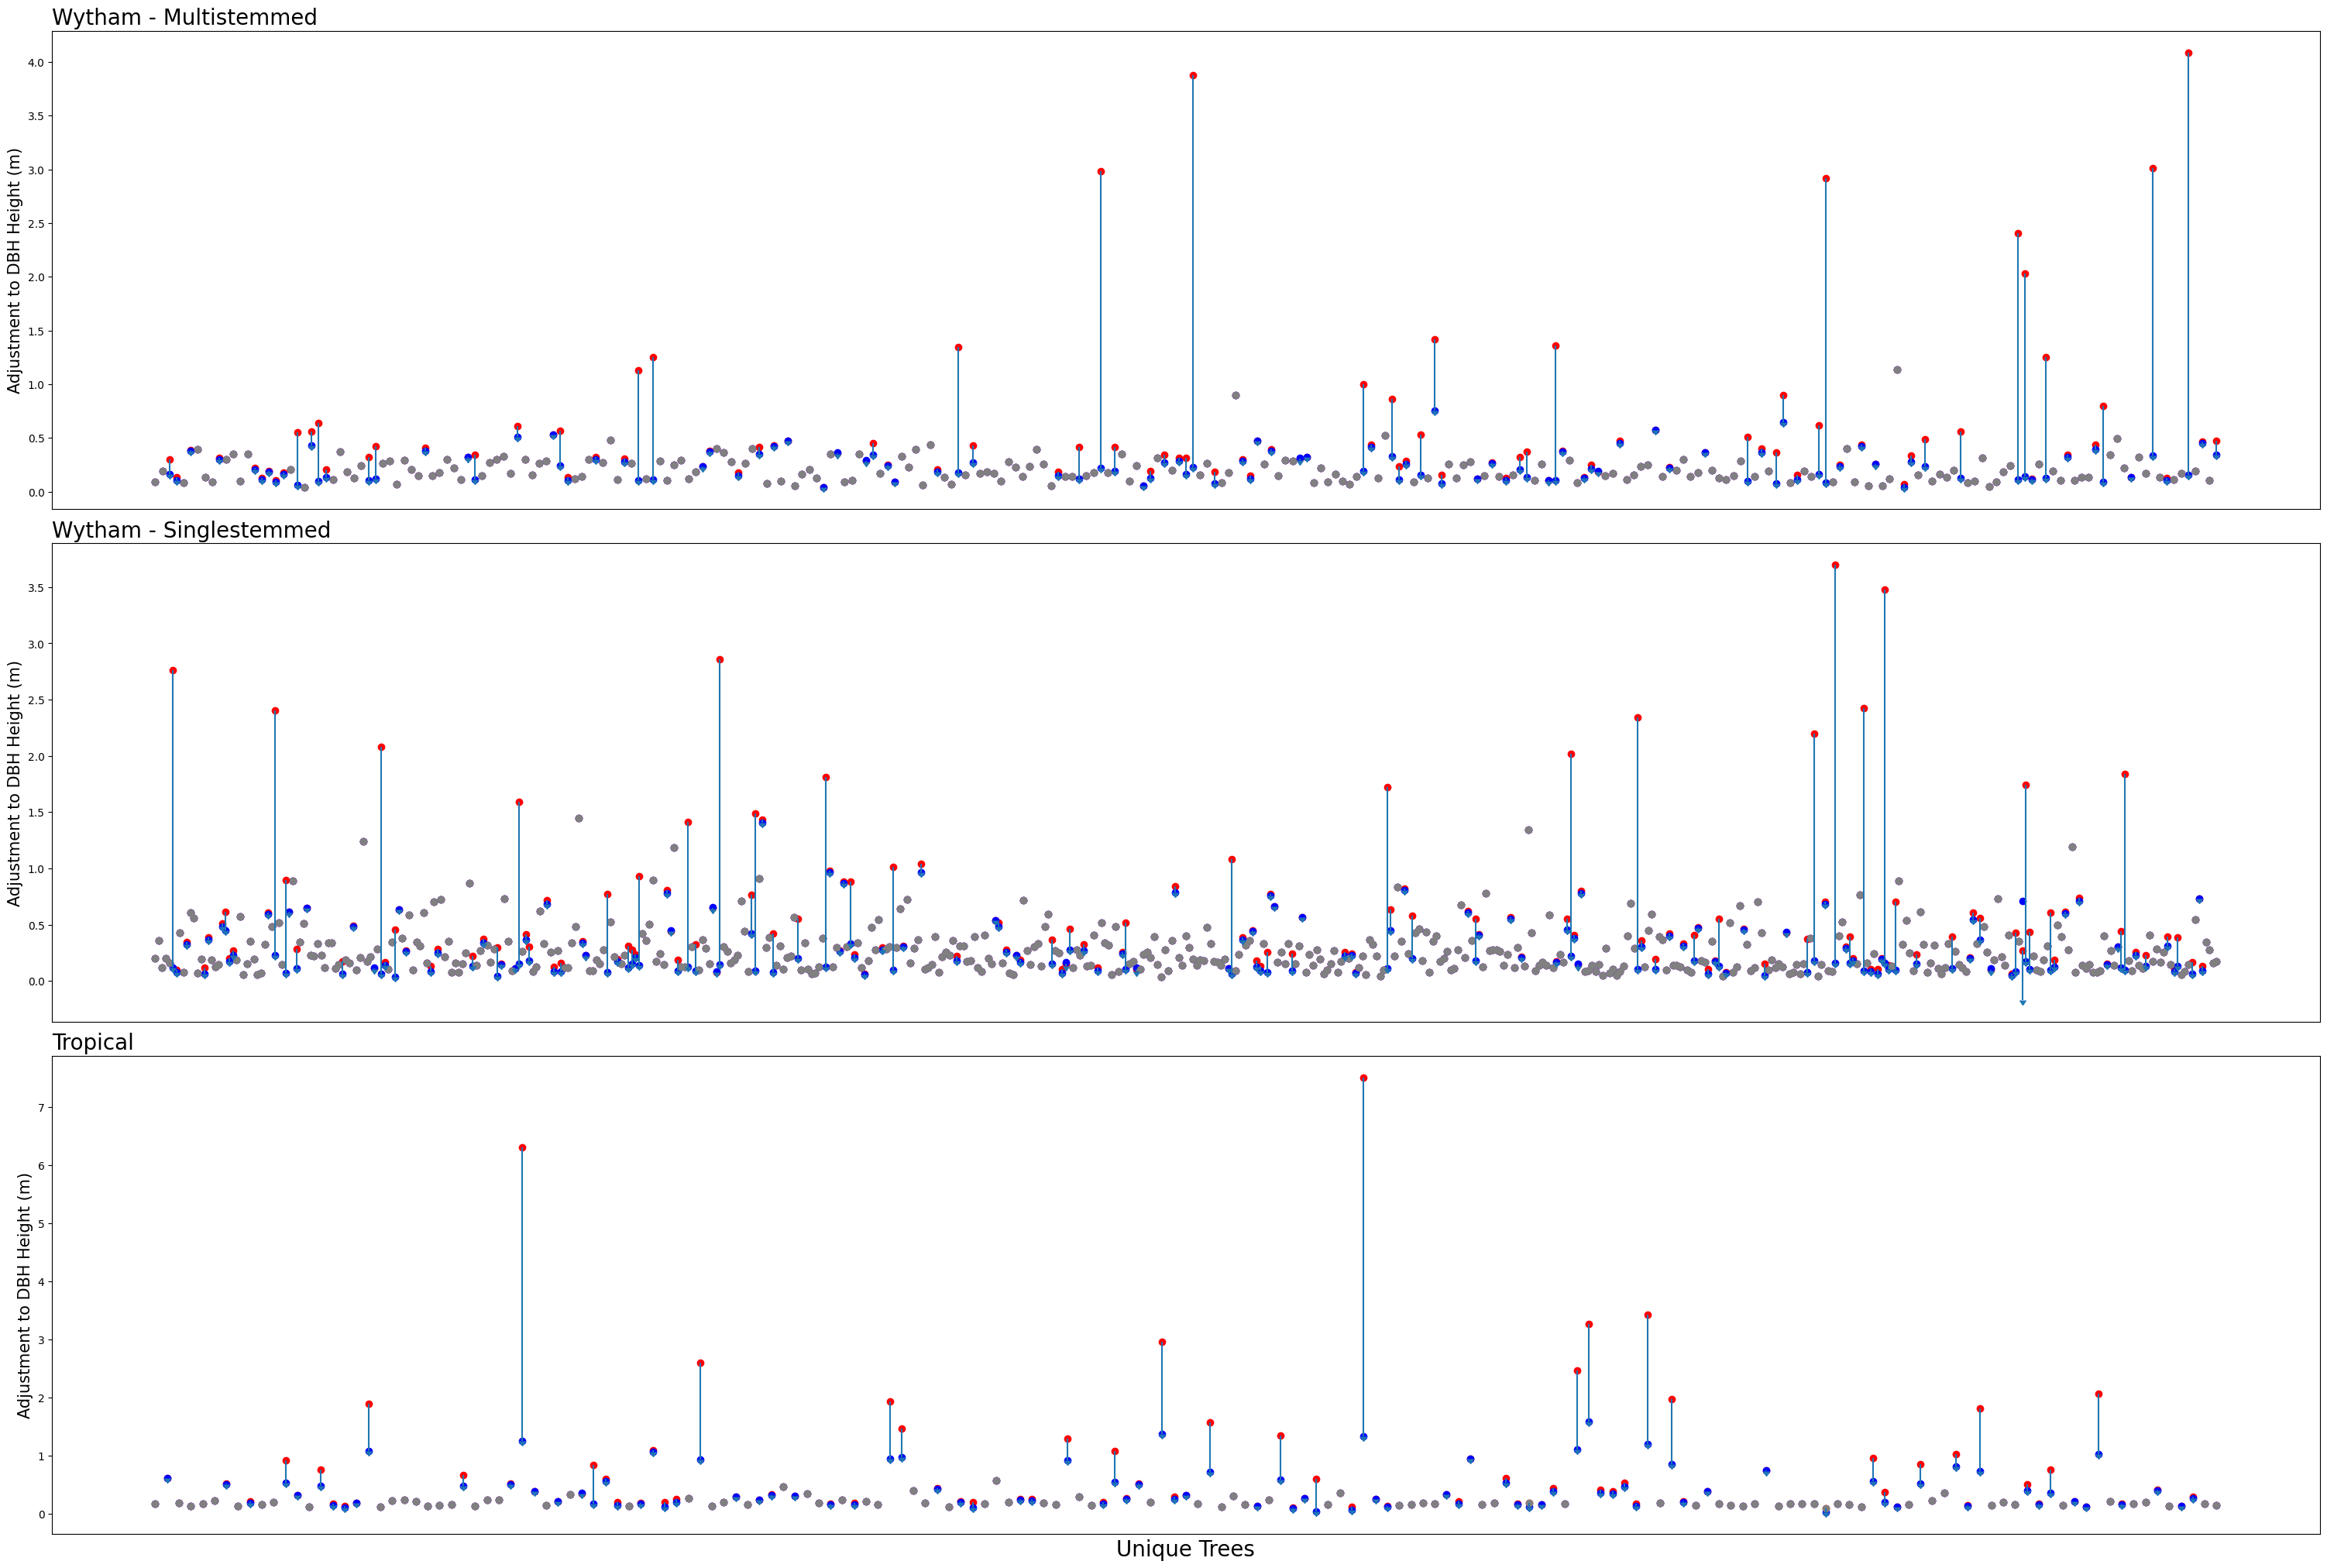

In [151]:
# plot the height at which dbh is measured for each tree (note most at 1.3m)
fig, axs = plt.subplots(3, 1, figsize=(30,20))
plt.tight_layout()

rowind = treeind = 0

for df in merged_dfs:

    # create dataset of only the points where the adjusted dbh height was 1.3 to mask these values
    
    mask13 = df[df['dbh_hgt'] == 1.3]

    axs[rowind].scatter(df['TLS_ID'], df['dbh13'], color='red', label="adjusted dbh")
    axs[rowind].scatter(df['TLS_ID'], df['dbhadj'], color='blue', label="dbh at 1.3m")
    axs[rowind].scatter(mask13['TLS_ID'], mask13['dbh13'], color='gray', label="no adjustment") # mask points where adjusted dbh height was 1.3
    axs[rowind].get_xaxis().set_ticks([])
    axs[rowind].set_ylabel('Adjustment to DBH Height (m)', fontsize=15)
    
    yerr = abs(df['dbhadj'] - df['dbh13'])
    axs[rowind].errorbar(df['TLS_ID'], df['dbh13'], yerr, uplims=yerr, ls='none', label="difference (adjusted vs. 1.3m)")

    #plt.legend(loc="upper right", fontsize=30)
    
    treeind, colind, rowind = update_inds(treeind, rowind, colind, ncols=1)

axs[0].set_title('Wytham - Multistemmed', loc='left', fontsize=20)
axs[1].set_title('Wytham - Singlestemmed', loc='left', fontsize=20)
axs[2].set_title('Tropical', loc='left', fontsize=20)
axs[2].set_xlabel('Unique Trees', fontsize=20)

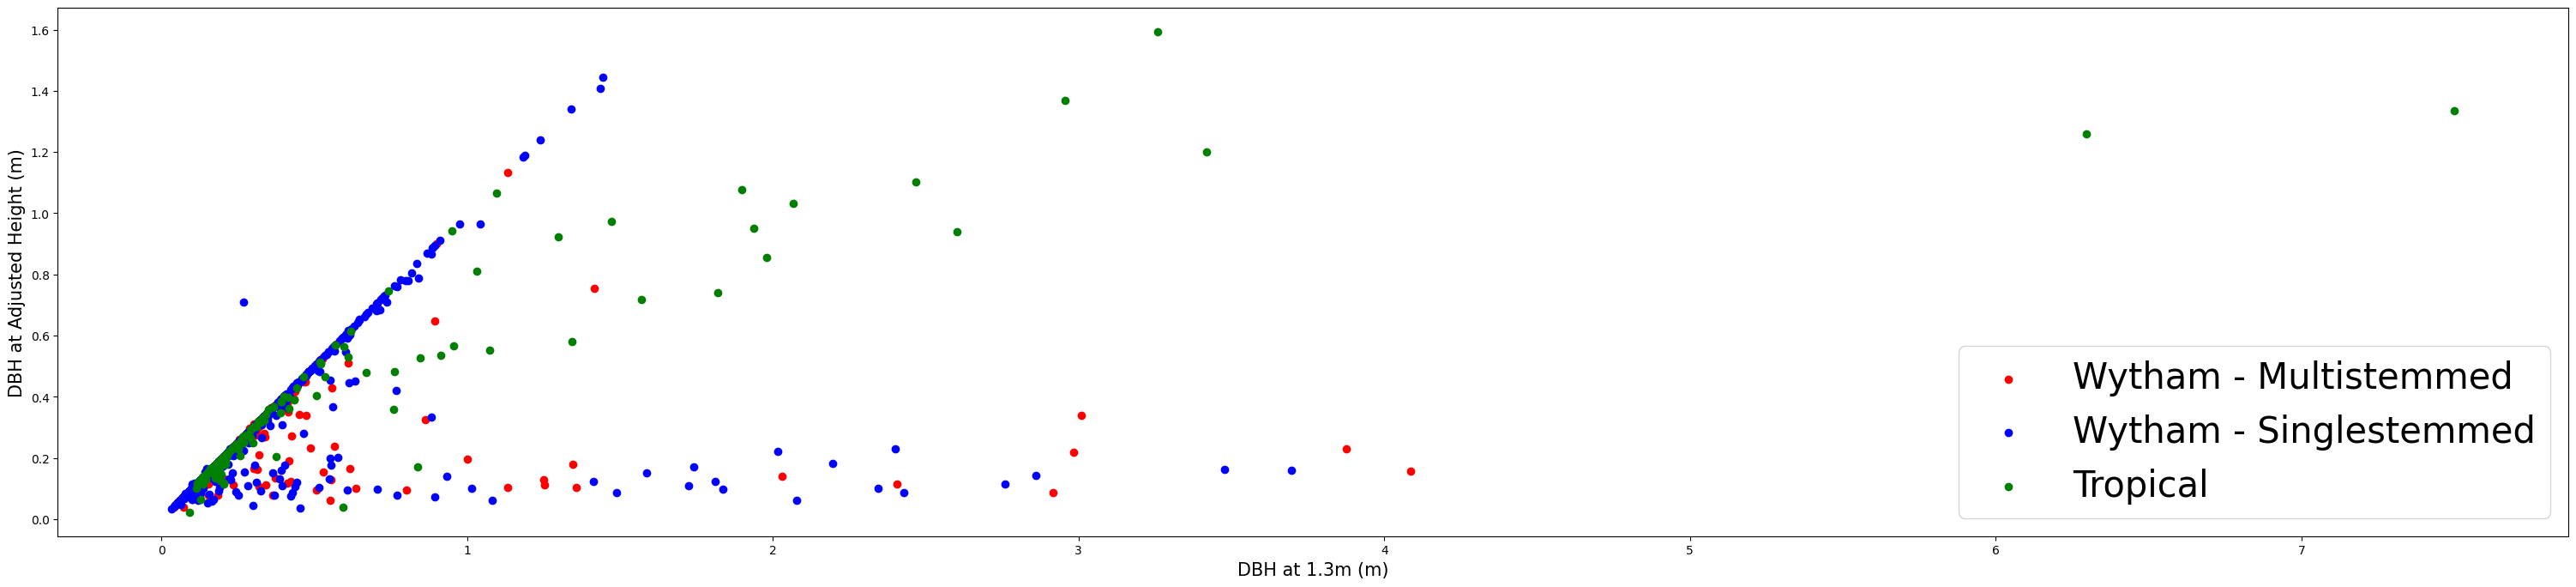

In [152]:
# plot the height at which dbh is measured for each tree (note most at 1.3m)
fig, axs = plt.subplots(1, 1, figsize=(30,10))
plt.tight_layout()

rowind = treeind = 0
colors = ['red', 'blue', 'green']
labels = ['Wytham - Multistemmed', 'Wytham - Singlestemmed', 'Tropical']

for df in merged_dfs:
    color = colors[treeind]
    label = labels[treeind]

    axs.scatter(df['dbh13'], df['dbhadj'], color=color, label=label)
    axs.set_aspect('equal')
    axs.set_ylabel('DBH at Adjusted Height (m)', fontsize=15)
    axs.set_xlabel('DBH at 1.3m (m)', fontsize=15)

    plt.legend(loc="lower right", fontsize=30)
    
    treeind, colind, rowind = update_inds(treeind, rowind, colind, ncols=1)


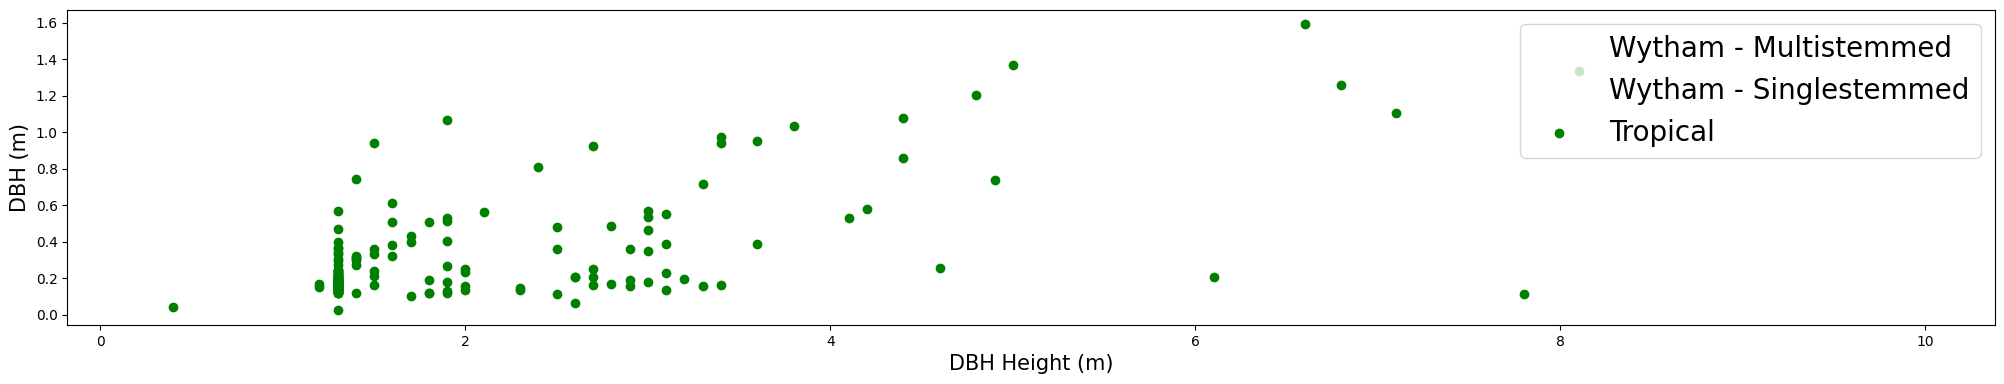

In [153]:
# plot the height at which dbh is measured for each tree (note most at 1.3m)
fig, axs = plt.subplots(1, 1, figsize=(20,30))
plt.tight_layout()

rowind = treeind = 0
colors = ['white', 'white', 'green']
labels = ['Wytham - Multistemmed', 'Wytham - Singlestemmed', 'Tropical']

for df in merged_dfs:
    color = colors[treeind]
    label = labels[treeind]

    axs.scatter(df['dbh_hgt'], df['dbhadj'], color=color, label=label)
    axs.set_aspect('equal')
    axs.set_ylabel('DBH (m)', fontsize=15)
    axs.set_xlabel('DBH Height (m)', fontsize=15)

    plt.legend(loc="upper right", fontsize=20)
    
    treeind, colind, rowind = update_inds(treeind, rowind, colind, ncols=1)

In [ ]:
plotlist = ['5a', '5b', '20a', '20b', '145a', '145c', '145e']

In [ ]:
# plot convex hull results using fixed 1.3m dbh height
plot_convexhull(plotlist, pts_path, ncols=4, fixedheight = True, hgt=1.3, hgtlist = hgt_dict)

# plot convex hull results 
plot_convexhull(plotlist, pts_path, ncols=4, fixedheight = False, hgt=1.3, hgtlist = hgt_dict)

In [ ]:
plot_iter_dbh(plotlist, pts_path, ncols = 2, step=0.1, slope_thresh=0.1)

In [ ]:
plot2D(plotlist, pts_path, ncols=3, dbh=False, iterdbh=True, hgtlist = hgt_dict)

In [167]:
wytham_ms_df[wytham_ms_df['TLS_ID'] == '180b']['stems'].iloc[0]

1

# How Circular?

In [174]:
# set threshold values for buttress slope and trunk irregularities
slope_thresh = 0.1
dbh_thresh = 2

# create list of treelists and output paths
treelists = [multistemmed, singlestemmed, trop_trees]
dbh_df_list = [wytham_ms_df, wytham_ss_df, trop_df]
ptspathlist = [wytham_pts_path, wytham_pts_path, trop_pts_path]

merged_dfs = []

# cycle through trees, get residuals and plot circle fits
for i in range (len(treelists)):
    treelist = treelists[i]
    ptspath = ptspathlist[i]
    o_path = opathlist[i]
    dbh_df = dbh_df_list[i]
    
    # create empty dictionaries to hold data
    residu_dict = {}
    dbh_circ_dict = {}
    
    for tree in treelist:

        tree, tree_num = construct_treeid(tree, ptspath)
        
        nstems = dbh_df[dbh_df['TLS_ID'] == tree_num]['stems'].iloc[0]

        hgt_dict = dict(zip(dbh_df.TLS_ID, dbh_df.dbh_hgt))
        
        # wytham dataset is already broken into single stems - run circular function on single stems only
        if treelist == multistemmed or treelist == singlestemmed:
            nstems = 1

        # run circular function for the given tree
        datadict = how_circular(tree, ptspath, nstems = nstems, fixedheight = False, hgtlist = hgt_dict)

        resid_list = []
        dbh_list = []

        # unroll and plot dictionary data for each stem
        for label in datadict.keys():

            xc = datadict[label]['xc']
            yc = datadict[label]['yc']
            dbh_circ = datadict[label]['dbh_circ']
            residu = datadict[label]['residual']
            pts_dbh = datadict[label]['circle_pts']
            hgt = datadict[label]['hgt']

            # plotting 
            theta_fit = np.linspace(-pi, pi, 180)
            x_fit = xc + (dbh_circ / 2.0)*np.cos(theta_fit)
            y_fit = yc + (dbh_circ / 2.0)*np.sin(theta_fit)

            #axs[rowind, colind].scatter(pts_dbh['x'], pts_dbh['y'])
            #axs[rowind, colind].plot(x_fit, y_fit, 'b-' , label=f"residu={residu:.4f}", lw=2,zorder=5)
            #axs[rowind, colind].plot([xc], [yc], 'bD', mec='y', mew=1)
            #axs[rowind, colind].set_title(f'Circle fit for{tree_num}', fontsize=20)
            #axs[rowind, colind].legend(loc='upper right')

            #axs[rowind, colind].set_aspect('equal')

            # add residual to list
            resid_list.append(residu)
            dbh_list.append(dbh_circ)

        # average the residuals for the given tree 
        avg_resid = np.mean(resid_list)
        sum_dbh = np.sum(dbh_list)

        # fill dictionaries
        residu_dict[tree_num] = avg_resid
        dbh_circ_dict[tree_num] = sum_dbh
        
        # list of dicts and columns
        dicts = [residu_dict, dbh_circ_dict]
        cols = ['residuals', 'dbh_circ']

    dfs = []
    for data_dict, column_name in zip(dicts, cols):
        df = pd.DataFrame.from_dict(data_dict, orient='index').reset_index()
        df.columns = ['TLS_ID', column_name]
        dfs.append(df)
    # merge resulting dataframes into one large dataframe 
    residual_df = dfs[0].merge(dfs[1],on='TLS_ID')

    merged_dfs.append(residual_df)

    # update indices and move to next subplot
    treeind, colind, rowind = update_inds(treeind, rowind, colind, ncols=4)



tree_num: 180b
tree_num: 8075b
tree_num: 2053c
tree_num: 8079a
tree_num: 2024a
tree_num: 138b
tree_num: 354b
tree_num: 8107d
tree_num: 8311a
tree_num: 1075a
tree_num: 122a
tree_num: 712b
tree_num: 9107a
tree_num: 250b
tree_num: 899a
tree_num: 175a
tree_num: 2049a
tree_num: 712c
tree_num: 1278b
tree_num: 1501b
tree_num: 817b
tree_num: 2053b
tree_num: 180a
tree_num: 8075a
tree_num: 2024b
tree_num: 8079b
tree_num: 138a
tree_num: 354a
tree_num: 8311b
tree_num: 1075b
tree_num: 8222d
tree_num: 857d
tree_num: 712a
tree_num: 122b
tree_num: 9107b
tree_num: 250a
tree_num: 899b
tree_num: 175b
tree_num: 175c
tree_num: 899c
tree_num: 122c
tree_num: 1278a
tree_num: 1501a
tree_num: 2053a
tree_num: 817a
tree_num: 8222a
tree_num: 8107b
tree_num: 857a
tree_num: 945a
tree_num: 416a
tree_num: 174b
tree_num: 197a
tree_num: 122f
tree_num: 8107c
tree_num: 640a
tree_num: 705a
tree_num: 139a
tree_num: 2053d
tree_num: 532b
tree_num: 9110b
tree_num: 1035b
tree_num: 122d
tree_num: 857b
tree_num: 945b
tree_num: 17

tree_num: 8313
tree_num: 284
tree_num: 253
tree_num: 8111
tree_num: 1121
tree_num: 1109
tree_num: 2366
tree_num: 8139
tree_num: 735
tree_num: 1862
tree_num: 709
tree_num: 9231
tree_num: 1484
tree_num: 2172
tree_num: 8339
tree_num: 286
tree_num: 8305
tree_num: 325
tree_num: 1296
tree_num: 1255
tree_num: 8098
tree_num: 1080
tree_num: 8067
tree_num: 1043
tree_num: 8073
tree_num: 1731
tree_num: 1730
tree_num: 8072
tree_num: 8066
tree_num: 1081
tree_num: 1254
tree_num: 1240
tree_num: 442
tree_num: 8304
tree_num: 8338
tree_num: 913
tree_num: 8112
tree_num: 9230
tree_num: 29
tree_num: 1877
tree_num: 1661
tree_num: 1107
tree_num: 513
tree_num: 8335
tree_num: 8321
tree_num: 8309
tree_num: 1339
tree_num: 301
tree_num: 473
tree_num: 1271
tree_num: 1517
tree_num: 2022
tree_num: 1926
tree_num: 8043
tree_num: 8056
tree_num: 8042
tree_num: 1927
tree_num: 664
tree_num: 499
tree_num: 472
tree_num: 300
tree_num: 8308
tree_num: 8320
tree_num: 1476
tree_num: 8334
tree_num: 260
tree_num: 31
tree_num: 9228


In [175]:
merged_dfs

[    TLS_ID  residuals  dbh_circ
 0     180b   0.000082  0.106998
 1    8075b   0.000871  0.129244
 2    2053c   0.000252  0.132392
 3    8079a   0.000218  0.099426
 4    2024a   0.000102  0.064749
 ..     ...        ...       ...
 286  8113a   0.000508  0.114640
 287  8406a   0.000186  0.163492
 288     5a   0.000215  0.415996
 289  8099c   0.000201  0.067663
 290   818a   0.000122  0.307292
 
 [291 rows x 3 columns],
     TLS_ID  residuals  dbh_circ
 0     1623   0.000168  0.166835
 1     1179   0.003237  0.273962
 2     2316   0.000033  0.105305
 3     1384   0.000166  0.166352
 4     9096   0.000050  0.137709
 ..     ...        ...       ...
 580   8150   0.000086  0.076251
 581    979   0.000090  0.312345
 582   8178   0.002057  0.177923
 583   8193   0.000194  0.114699
 584   1821   0.000082  0.141930
 
 [585 rows x 3 columns],
     TLS_ID  residuals  dbh_circ
 0      T38   0.000043  0.153172
 1      T39   0.001130  0.575220
 2     T187   0.000057  0.159470
 3     T115   0.000065

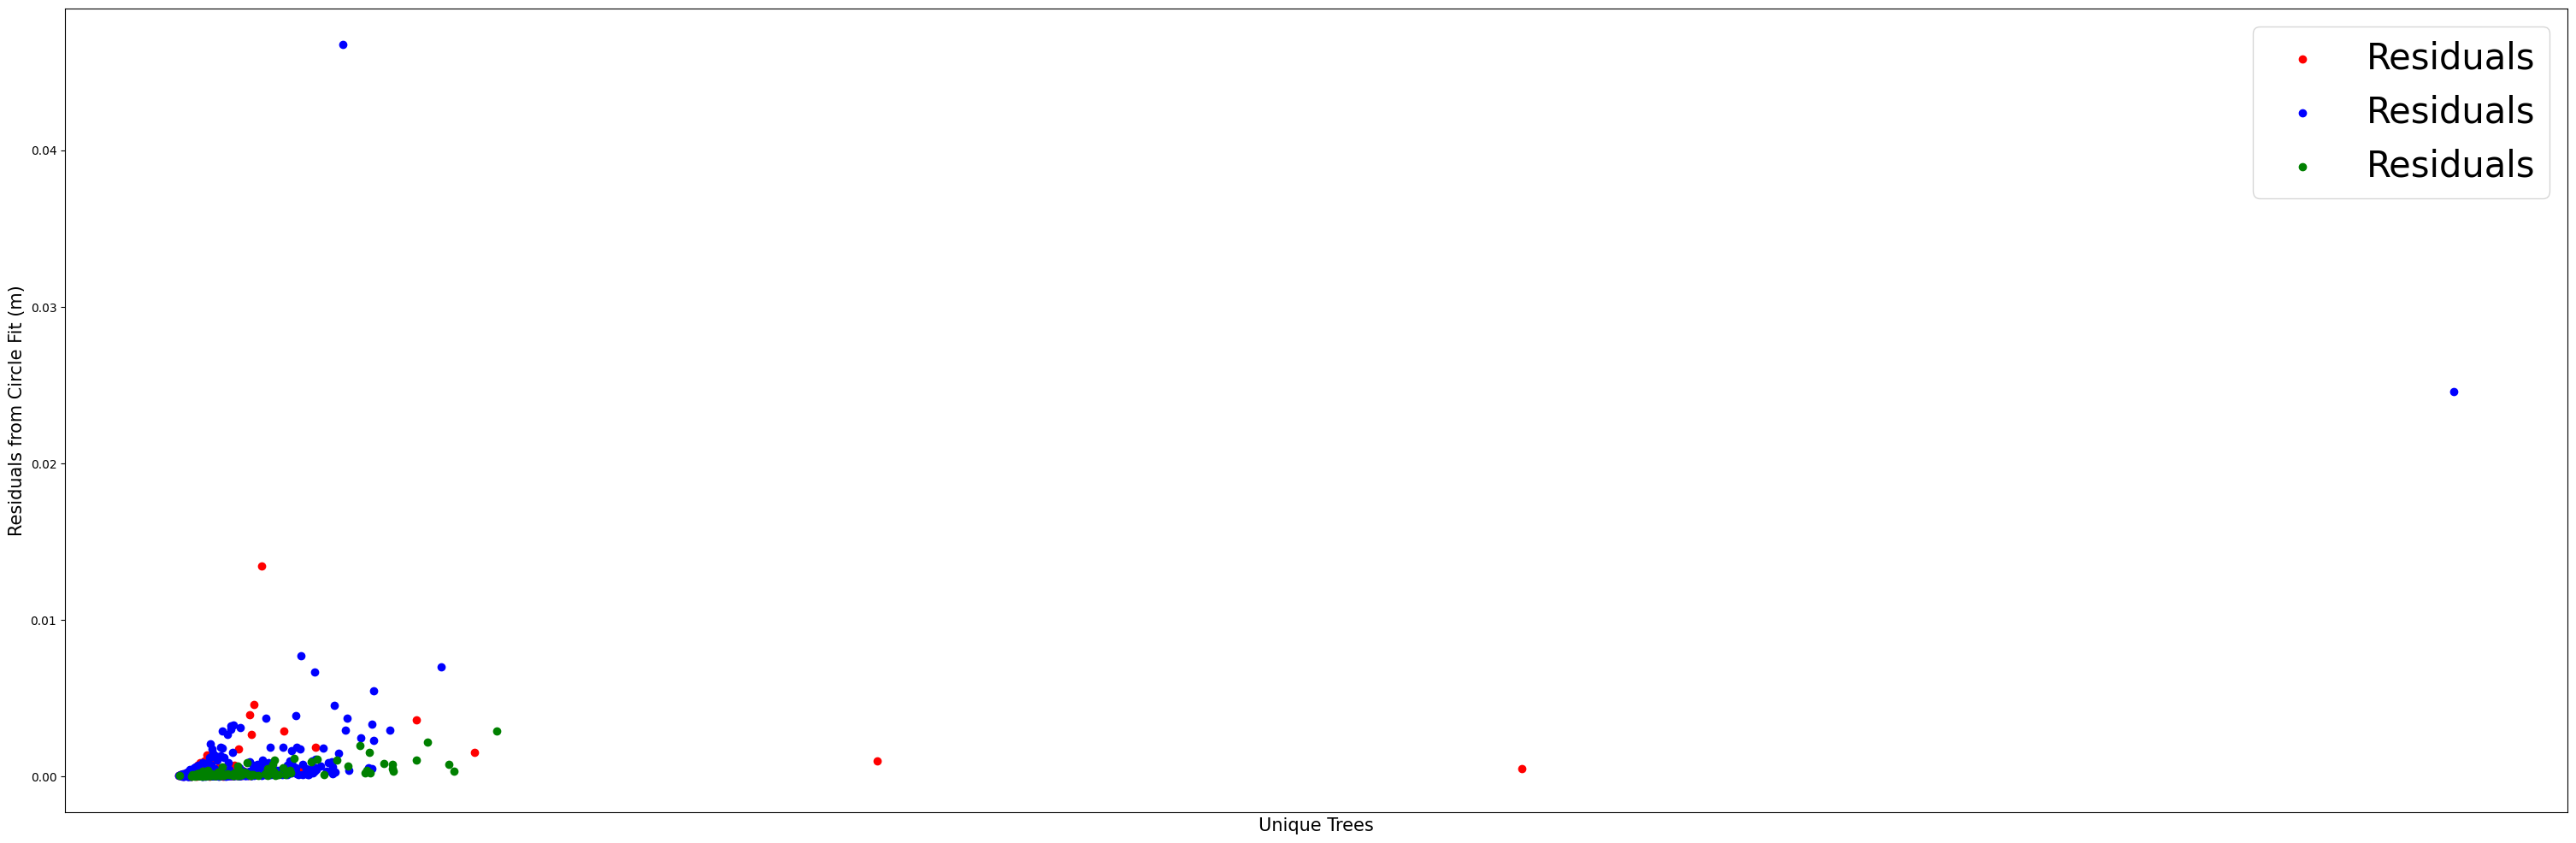

In [178]:
merged_dfs


# plot residuals
fig, axs = plt.subplots(1, 1, figsize=(30,10))
plt.tight_layout()

rowind = treeind = 0
colors = ['red', 'blue', 'green']
#labels = ['Wytham - Multistemmed', 'Wytham - Singlestemmed', 'Tropical']

dicts = [residu_dict, dbh_circ_dict]
cols = ['residuals', 'dbh_circ']

# merge resulting dataframes into one large dataframe 
residual_df = dfs[0].merge(dfs[1],on='TLS_ID')

for residual_df in merged_dfs:
    color = colors[treeind]

    axs.scatter(residual_df['dbh_circ'], residual_df['residuals'], color = color, label='Residuals')
    #axs.set_aspect('equal')
    axs.set_ylabel('Residuals from Circle Fit (m)', fontsize=15)
    axs.set_xlabel('Unique Trees', fontsize=15)
    axs.get_xaxis().set_ticks([])

    plt.legend(loc="upper right", fontsize=30)

    treeind, colind, rowind = update_inds(treeind, rowind, colind, ncols=1)


# Sensitivity Testing - Slope Thresholds

### Run functions with varying slope thresholds

In [ ]:
# big dictionaries of dataframes with sensitivity data 
slope_sensitivity_dict = {}

# set list of trees to run convex hull on 
treelist = singlestemmed

# list of threshold values to test
slope_thresh_vals = [0.07, 0.1, 0.2, 0.3, 0.4, 0.5]

# cycle through threshold values for one variable
for slope_thresh in slope_thresh_vals:
    # hold other threshold value constant
    dbh_thresh = 2
    
    print(f'slope_thresh: {slope_thresh}, dbh_thresh: {dbh_thresh}')
    
    # create empty dictionaries to hold data
    hgt_dict = {}
    dbh_13_dict = {}
    dbh_adj_dict = {}

    # cycle through trees and fill dictionaries with optimal height and convex hull values
    for tree in treelist:
        tree, tree_num = construct_treeid(tree, trop_pts_path)

        # calculate convex hull at 1.3m
        dbh_13, verts_13, pts_dbh_13, hull_13 = calc_convexhull(tree, trop_pts_path, hgt=1.3)
        dbh_13_dict[tree_num] = dbh_13

        # determine optimal height from which to calculate dbh
        hgt = get_dbh_hgt(tree, trop_pts_path, step=0.1, slope_thresh=slope_thresh, lim=10, dbh_thresh=dbh_thresh)
        hgt_dict[tree_num] = hgt

        #print(f'{tree_num} hgt: {hgt}')

        # calculate convex hull at optimal height 
        dbh_adj, verts_adj, pts_dbh_adj, hull_adj = calc_convexhull(tree, trop_pts_path, hgt=hgt)
        dbh_adj_dict[tree_num] = dbh_adj
    
    # convert each dictionary to dataframe and rename columns
    hgt = pd.DataFrame.from_dict(hgt_dict, orient='index').reset_index()
    hgt.columns = ['TLS_ID', 'hgt']

    dbh13 = pd.DataFrame.from_dict(dbh_13_dict, orient='index').reset_index()
    dbh13.columns = ['TLS_ID', 'dbh13']

    dbhadj = pd.DataFrame.from_dict(dbh_adj_dict, orient='index').reset_index()
    dbhadj.columns = ['TLS_ID', 'dbhadj']

    # create dataframe for the list of trees with optimal height and convex hull values
    trop_treedata = pd.merge(pd.merge(hgt, dbh13, on ='TLS_ID'), dbhadj, on ='TLS_ID')
    
    # add dataframe to dictionary
    slope_sensitivity_dict[slope_thresh] = trop_treedata

### Count Number of Adjustments

In [ ]:
for slope_thresh in slope_sensitivity_dict.keys():
    datadict = slope_sensitivity_dict[slope_thresh]
    adjusted = datadict[datadict['hgt'] != 1.3]
    differences = np.mean(datadict['dbhadj'] - datadict['dbh13'])
    print(f'slope thresh {slope_thresh} - {len(adjusted)} adjustments - mean dif: {differences:.2f}')

### Plot Sensitivity to Slope Threshold

In [ ]:
ncols = 2
fig, axs = formatplots(slope_sensitivity_dict.keys(), ncols=ncols, shape='horiz')
rowind = colind = treeind = 0
        
for slope_thresh in slope_sensitivity_dict.keys():
    datadict = slope_sensitivity_dict[slope_thresh]
    
    mask13 = datadict[datadict['hgt'] == 1.3]
    
    axs[rowind, colind].get_xaxis().set_ticks([])
    axs[rowind, colind].set_title(f'Adjusted vs Original DBH Values (Slope Threshold: {slope_thresh})')
    
    axs[rowind, colind].scatter(datadict['TLS_ID'], datadict['dbh13'], color='red', label="adjusted dbh")
    axs[rowind, colind].scatter(datadict['TLS_ID'], datadict['dbhadj'], color='blue', label="dbh at 1.3m")
    axs[rowind, colind].scatter(mask13['TLS_ID'], mask13['dbh13'], color='gray', label="no adjustment") # mask points where adjusted dbh height was 1.3

    yerr = abs(datadict['dbhadj'] - datadict['dbh13'])
    axs[rowind, colind].errorbar(datadict['TLS_ID'], datadict['dbh13'], yerr, uplims=yerr, ls='none', label="difference (adjusted vs. 1.3m)")
    

    treeind, colind, rowind = update_inds(treeind, rowind, colind, ncols)

fig.tight_layout()
handles, labels = axs[0,0].get_legend_handles_labels()
#fig.legend(handles, labels, fontsize=15, bbox_to_anchor=(0.998, 0.978)) # manually placing legend

In [ ]:
#minilist = ['T207', 'T169', 'T44', 'T206', 'T102', 'T38'] 

minilist = ['8022', '8340', '2312', '8388', '1623', '1179'] 

for slope_thresh in slope_thresh_vals:
    print(slope_thresh)
    plot_iter_dbh(minilist, pts_path, ncols = 2, step=0.1, slope_thresh=slope_thresh)

# Sensitivity Testing - DBH Irregularity Thresholds

In [ ]:
# big dictionaries of dataframes with sensitivity data 
dbh_sensitivity_dict = {}

# set list of trees to run convex hull on 
treelist = singlestemmed

# list of threshold values to test
dbh_thresh_vals = [1.2, 1.5, 2, 2.5, 3, 3.5]

# cycle through threshold values for one variable
for dbh_thresh in dbh_thresh_vals:
    # hold other threshold value constant
    slope_thresh = 0.1
    
    print(f'dbh_thresh: {dbh_thresh}, slope_thresh: {slope_thresh}')
    
    # create empty dictionaries to hold data
    hgt_dict = {}
    dbh_13_dict = {}
    dbh_adj_dict = {}
    irreg_dict = {}

    # cycle through trees and fill dictionaries with optimal height and convex hull values
    for tree in treelist:
        tree, tree_num = construct_treeid(tree, trop_pts_path)

        # calculate convex hull at 1.3m
        dbh_13, verts_13, pts_dbh_13, hull_13 = calc_convexhull(tree, trop_pts_path, hgt=1.3)
        dbh_13_dict[tree_num] = dbh_13

        # determine optimal height from which to calculate dbh
        hgt = get_dbh_hgt(tree, trop_pts_path, step=0.1, slope_thresh=slope_thresh, lim=10, dbh_thresh=dbh_thresh)
        hgt_dict[tree_num] = hgt

        #print(f'{tree_num} hgt: {hgt}')

        # calculate convex hull at optimal height 
        dbh_adj, verts_adj, pts_dbh_adj, hull_adj = calc_convexhull(tree, trop_pts_path, hgt=hgt)
        dbh_adj_dict[tree_num] = dbh_adj
        
        # flag irregular function 
        irreg_df = flag_irregular(tree, trop_pts_path, step=0.1, slope_thresh=slope_thresh, lim=10, dbh_thresh = dbh_thresh)
        irregs = len(irreg_df[irreg_df['Flagged'] == 1])
        irreg_dict[tree_num] = irregs
    
    
    # convert each dictionary to dataframe and rename columns
    hgt = pd.DataFrame.from_dict(hgt_dict, orient='index').reset_index()
    hgt.columns = ['TLS_ID', 'hgt']

    dbh13 = pd.DataFrame.from_dict(dbh_13_dict, orient='index').reset_index()
    dbh13.columns = ['TLS_ID', 'dbh13']

    dbhadj = pd.DataFrame.from_dict(dbh_adj_dict, orient='index').reset_index()
    dbhadj.columns = ['TLS_ID', 'dbhadj']
    
    irreg = pd.DataFrame.from_dict(irreg_dict, orient='index').reset_index()
    irreg.columns = ['TLS_ID', 'irregs']

    # create dataframe for the list of trees with optimal height and convex hull values
    trop_treedata = pd.merge(pd.merge(pd.merge(hgt, dbh13, on ='TLS_ID'), dbhadj, on ='TLS_ID'), irreg, on='TLS_ID')
    
    # add dataframe to dictionary
    dbh_sensitivity_dict[dbh_thresh] = trop_treedata

In [ ]:
for dbh_thresh in dbh_sensitivity_dict.keys():
    datadict = dbh_sensitivity_dict[dbh_thresh]
    adjusted = datadict[datadict['hgt'] != 1.3]
    differences = np.mean(datadict['dbhadj'] - datadict['dbh13'])
    irreg_num = np.mean(datadict['irregs'])
    print(f'dbh thresh {dbh_thresh} - {len(adjusted)} adjustments - mean dif: {differences:.2f}, flagged {irreg_num}')

In [ ]:
from matplotlib import cm
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

#fig, axs = formatplots(dbh_sensitivity_dict.keys(), ncols=ncols, shape='horiz')
#rowind = colind = treeind = 0

fig = plt.figure(figsize=(20, 10))

# get colormap for plotting with 6 colors
cmap = plt.colormaps['inferno'].resampled(6)
newcolors = cmap(np.linspace(0, 1, 6))

# create the lines connecting dots to help with visualization
high_thresh = dbh_sensitivity_dict[3.5]
low_thresh = dbh_sensitivity_dict[1.2]
yerr = abs(high_thresh['irregs'] - low_thresh['irregs'])
plt.errorbar(datadict['TLS_ID'], low_thresh['irregs'], yerr, uplims=yerr, ls='none', color='gray', linewidth=0.5, zorder = 0, fmt='none')

# loop through threshold values and plot on the same figure
i = 0
for dbh_thresh in dbh_sensitivity_dict.keys():
    datadict = dbh_sensitivity_dict[dbh_thresh]
    color = newcolors[i]
    plt.scatter(datadict['TLS_ID'], datadict['irregs'], color=color, label="adjusted dbh")
    
    i += 1
    

In [ ]:
ncols = 2
fig, axs = formatplots(dbh_sensitivity_dict.keys(), ncols=ncols, shape='horiz')
rowind = colind = treeind = 0
        
for dbh_thresh in dbh_sensitivity_dict.keys():
    datadict = dbh_sensitivity_dict[dbh_thresh]
    
    mask13 = datadict[datadict['hgt'] == 1.3]
    
    axs[rowind, colind].get_xaxis().set_ticks([])
    axs[rowind, colind].set_title(f'Adjusted vs Original DBH Values (DBH Threshold: {dbh_thresh})')
    
    axs[rowind, colind].scatter(datadict['TLS_ID'], datadict['dbh13'], color='red', label="adjusted dbh")
    axs[rowind, colind].scatter(datadict['TLS_ID'], datadict['dbhadj'], color='blue', label="dbh at 1.3m")
    axs[rowind, colind].scatter(mask13['TLS_ID'], mask13['dbh13'], color='gray', label="no adjustment") # mask points where adjusted dbh height was 1.3

    yerr = abs(datadict['dbhadj'] - datadict['dbh13'])
    axs[rowind, colind].errorbar(datadict['TLS_ID'], datadict['dbh13'], yerr, uplims=yerr, ls='none', label="difference (adjusted vs. 1.3m)")
    

    treeind, colind, rowind = update_inds(treeind, rowind, colind, ncols)

fig.tight_layout()
handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, fontsize=15, bbox_to_anchor=(0.998, 0.978)) # manually placing legend

# Predict DBH:

In [ ]:
treecsv = pd.read_csv(tree_csv_path)


treecsv = treecsv[['TLS_ID','stemlocx_[m]', 'stemlocy_[m]', 'DBH_TLS_[m]',
                    'Hgt_pts_[m]', 'VerticalCrownProjectedArea_pts_[m2]', 'Vol_QSM_avg_[m3]',
                    'Vol_QSM_D0_25mm_avg_[m3]', 'Vol_QSM_D25_50mm_avg_[m3]', 'Vol_QSM_D50_75mm_avg_[m3]',
                    'Vol_QSM_D75_100mm_avg_[m3]', 'Vol_QSM_D100_200mm_avg_[m3]', 'Vol_QSM_D200_500mm_avg_[m3]',
                    'Vol_QSM_D500_1000mm_avg_[m3]', 'Vol_QSM_D1000mm_avg_[m3]']]


treedata = pd.merge(big_datadf, treecsv, on ='TLS_ID')

treedata.head()

## Compare Convex Hull with "DBH_TLS[m]"

In [ ]:
# select only single stem trees from csv 
#ss_treedata = treecsv[treecsv[['TLS_ID']].apply(lambda x: x[-1].isdigit(), axis=1)]

#smalltrees = treedata[treedata['DBH_CV']<4]

plt.figure(figsize=(10,7))
plt.scatter(treedata['dbh_cv'], treedata['DBH_TLS_[m]'])
plt.xlabel('DBH from Convex Hull', fontsize=20)
plt.ylabel('DBH from TLS', fontsize=20)


## Random Forest (Predicting DBH from QSMs)

In [ ]:
#https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

# Labels are the values we want to predict
labels = np.array(treedata['dbh_cv'])

# Remove the labels from the features
# axis 1 refers to the columns
features = treedata.drop(['TLS_ID','dbh_cv', 'DBH_TLS_[m]'], axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

In [ ]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)



In [ ]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

In [ ]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')



In [ ]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

In [ ]:
#rf_results = pd.DataFrame(mape, predictions, test_labels)

rf_results = pd.DataFrame({'mape': mape, 'errors': errors,'predictions': predictions, 'test_labels': test_labels}, columns=['mape', 'errors', 'predictions', 'test_labels'])

plt.figure(figsize=(10,7))
plt.scatter(rf_results['predictions'], rf_results['test_labels'])
plt.xlabel('Predictions (DBH)', fontsize=20)
plt.ylabel('Measured Values (DBH)', fontsize=20)


In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(rf_results['test_labels'], rf_results['errors'])
plt.xlabel('Measured Values (DBH)', fontsize=20)
plt.ylabel('Errors', fontsize=20)

In [ ]:
# merge rf results back with original dataset
#https://stackoverflow.com/questions/40729162/merging-results-from-model-predict-with-original-pandas-dataframe
# TODO: in final - re-run model on full dataset and split into training vs testing

df_out = pd.merge(treedata,rf_results[['mape', 'errors', 'predictions']],how = 'left',left_index = True, right_index = True)

#rf_results.shape
df_out.head(150)

In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(df_out['verts'], df_out['errors'])
plt.xlabel('DBH Verts', fontsize=20)
plt.ylabel('Errors', fontsize=20)